# Multi-turn Multi-modal Optimizer Example

On an ubuntu/linux machine, install the following:

```
# Install Chrome
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo apt install -y ./google-chrome-stable_current_amd64.deb

# Install dependencies
sudo apt update
sudo apt install -y unzip xvfb libxi6 libgconf-2-4 libnss3
```

Install the following packages as well:
```
pip install selenium
```

In [2]:
import os
from opto.trace import bundle, node, GRAPH
import opto.optimizers
import importlib
import inspect
import json
import pickle
from opto.utils.llm import LLM

from opto import trace
from opto.trace import node, bundle
from opto.optimizers.optoprime_v3 import (
    OptoPrimeV3, ProblemInstance,
    Content, OptimizerPromptSymbolSetJSON
)
from opto.utils.backbone import TextContent, ImageContent, ContentBlock, ContentBlockList, UserTurn, AssistantTurn, ConversationHistory

We first create some reference material for the optimization:

In [5]:
import json
import math
from PIL import Image, ImageDraw, ImageFont

spec = """{
  "elements": [
    {
      "id": "title",
      "type": "text",
      "content": "Welcome",
      "x": 100,
      "y": 50,
      "fontSize": 24
    },
    {
      "id": "button",
      "type": "button",
      "content": "Submit",
      "x": 120,
      "y": 150,
      "width": 100,
      "height": 40
    }
  ]
}"""

HTML_TEMPLATE = """
<html>
<head>
<style>
  body {{ margin: 0; padding: 0; position: relative; width: 500px; height: 300px; }}
  .element {{ position: absolute; }}
</style>
</head>
<body>
{body}
</body>
</html>
"""

def spec_to_html(spec, filename="layout.html"):
    body = ""
    for e in spec["elements"]:
        if e["type"] == "text":
            body += f'<div class="element" style="left:{e["x"]}px; top:{e["y"]}px; font-size:{e["fontSize"]}px;">{e["content"]}</div>\n'
        elif e["type"] == "button":
            body += f'<button class="element" style="left:{e["x"]}px; top:{e["y"]}px; width:{e["width"]}px; height:{e["height"]}px;">{e["content"]}</button>\n'
            
    with open(filename, "w") as f:
        f.write(HTML_TEMPLATE.format(body=body))

In [18]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

def take_screenshot(html_path, output_img):
    opts = Options()
    opts.headless = True   # headless mode for automation

    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")
    options.add_argument("--allow-file-access-from-files")
    options.add_argument("--enable-local-file-accesses")

    driver = webdriver.Chrome(options=options)
    driver.get("file:///home/ubuntu/Trace/tests/" + html_path)
    driver.save_screenshot(output_img)
    driver.quit()

In [4]:
spec_to_html(spec = json.loads(spec))
take_screenshot("layout.html", "layout.png")

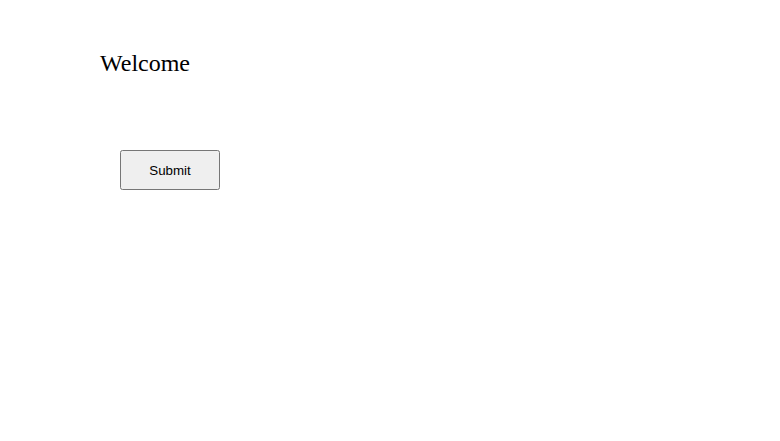

In [9]:
ImageContent("layout.png").show()

Now we have successfully took a screenshot of an HTML, we can start our optimization.

### Step 1: Using the multi-modal context block to provide a reference image 

The task is for the model to implement an HTML page according to the image

In [3]:
html_param = node("<html></html>", trainable=True)
optimizer = OptoPrimeV3([html_param], use_json_object_format=True,
                        memory_size=5,
                        ignore_extraction_error=False,
                        include_example=False,
                        optimizer_prompt_symbol_set=OptimizerPromptSymbolSetJSON())

optimizer.add_context("The reference image looks like this: ", ImageContent("./layout.png"))
optimizer.zero_feedback()

feedback_text = """Please fill in the empty HTML page such that it looks like the target image."""

optimizer.backward(html_param, feedback=feedback_text)

In [4]:
summary = optimizer.summarize()
system_prompt, user_content_blocks = optimizer.construct_prompt(summary)

In [5]:
for block in user_content_blocks:
    print(block)

TextContent(type='text', text='\nNow you see problem instance:\n\n================================\n \n# Instruction\nYou need to change the `value` of the variables in # Variables to improve the output in accordance to # Feedback.\n\n# Code\n\n\n# Documentation\n\n\n# Variables\n <variable name="str0" type="str">\n<value>\n<html></html>\n</value>\n</variable>\n\n \n\n# Inputs\n \n\n# Others\n \n\n# Outputs\n \n\n# Context\n The reference image looks like this: ')
ImageContent(image_url=None, image_data=iVBORw0KGg..., image_bytes=None, media_type=image/png)
TextContent(type='text', text='\n\n# Feedback\n Please fill in the empty HTML page such that it looks like the target image. \n================================\n\n \nWhat are your suggestions on variables str0?\n\nYour response:\n')


The above information might be hard to read, but we can also directly print this.

Note that the image becomes `[IMAGE]`, a placeholder in the text rendering (we are **not** sending this placeholder to the LLM)

In [6]:
print(user_content_blocks)


Now you see problem instance:

 
# Instruction
You need to change the `value` of the variables in # Variables to improve the output in accordance to # Feedback.

# Code


# Documentation


# Variables
 <variable name="str0" type="str">
<value>
<html></html>
</value>
</variable>

 

# Inputs
 

# Others
 

# Outputs
 

# Context
 The reference image looks like this:  
[IMAGE]
 

# Feedback
 Please fill in the empty HTML page such that it looks like the target image. 

 
What are your suggestions on variables str0?

Your response:



In [7]:
optimizer.step(verbose=True)

Prompt
 You're tasked to solve a coding/algorithm problem. You will see the instruction, the code, the documentation of each function used in the code, and the feedback about the execution result.

Specifically, a problem will be composed of the following parts:
- #Instruction: the instruction which describes the things you need to do or the question you should answer.
- #Code: the code defined in the problem.
- #Documentation: the documentation of each function used in #Code. The explanation might be incomplete and just contain high-level description. You can use the values in #Others to help infer how those functions work.
- #Variables: the input variables that you can change/tweak (trainable).
- #Inputs: the values of fixed inputs to the code, which CANNOT be changed (fixed).
- #Others: the intermediate values created through the code execution.
- #Outputs: the result of the code output.
- #Feedback: the feedback about the code's execution result.
- #Context: the context information

{<opto.trace.nodes.ParameterNode at 0x71c7c826dfd0>: '<html><body><h1>Welcome</h1><button>Submit</button></body></html>'}

In [8]:
print(html_param.data)

<html><body><h1>Welcome</h1><button>Submit</button></body></html>


In [9]:
def save_html_to_file(html, filename="new_layout.html"):
    with open(filename, "w") as f:
        f.write(html)

save_html_to_file(html_param.data)

## Step 2: Using visual feedback to guide optimization / HTML generation

In order to test if the LLM optimizer has true visual understanding, we want to test if it understands **visual feedback**. We use the following function to annotate the generated HTML

In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from PIL import Image, ImageDraw, ImageFont

def annotate_screenshot(html_path, output_img):
    options = Options()
    options.add_argument("--headless=new")
    # ... your other options ...

    driver = webdriver.Chrome(options=options)
    # Ensure you use the absolute path for the file URL
    driver.get("file:///home/ubuntu/Trace/tests/" + html_path)

    # 1. Find the button and get its location/size
    button = driver.find_element(By.TAG_NAME, "button")
    location = button.location  # {'x': 100, 'y': 200}
    size = button.size          # {'height': 30, 'width': 100}

    # 2. Save the initial screenshot
    driver.save_screenshot(output_img)
    driver.quit()

    # 3. Use PIL to draw the annotation
    img = Image.open(output_img)
    draw = ImageDraw.Draw(img)
    
    # Calculate positions
    # We'll point to the right side of the button
    arrow_start = (location['x'] + size['width'] + 50, location['y'] + (size['height'] // 2))
    arrow_end = (location['x'] + size['width'] + 5, location['y'] + (size['height'] // 2))
    text_pos = (arrow_start[0] + 5, arrow_start[1] - 10)

    # Draw a red arrow (line)
    draw.line([arrow_start, arrow_end], fill="red", width=3)
    # Draw a simple arrowhead
    draw.polygon([arrow_end, (arrow_end[0]+10, arrow_end[1]-5), (arrow_end[0]+10, arrow_end[1]+5)], fill="red")

    # Draw text
    # Note: To use a specific font size, you'll need to point to a .ttf file on your system
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
    except:
        font = ImageFont.load_default()

    draw.text(text_pos, "Make this bigger", fill="red", font=font)

    # Save the final annotated image
    img.save(output_img)

annotate_screenshot("new_layout.html", "new_layout_feedback.png")

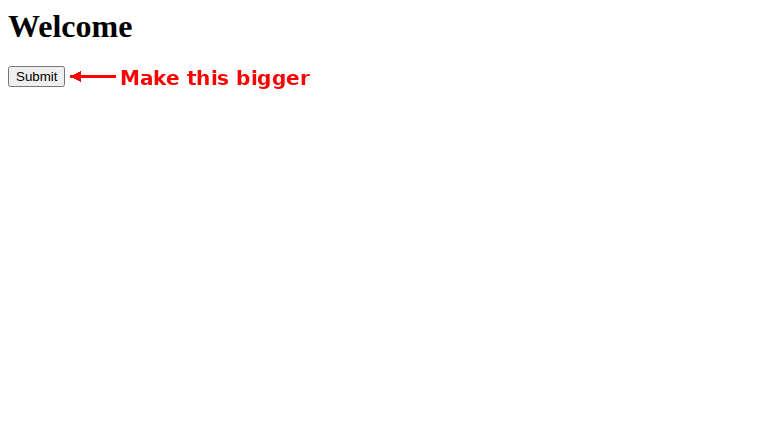

In [11]:
ImageContent("new_layout_feedback.png").show()

We essentially use an arrow and red text to indicate the feedback! Now let's see how to pass this in!

In [12]:
# 2nd optimization step!

optimizer.zero_feedback()

feedback_text = """Here’s the annotated visual feedback, please update the spec according to the annotation on the image."""

optimizer.backward(html_param, feedback=Content(feedback_text, ImageContent("./new_layout_feedback.png")))

In [13]:
summary = optimizer.summarize()
system_prompt, user_content_blocks = optimizer.construct_prompt(summary)

In [14]:
print(user_content_blocks)


Now you see problem instance:

 
# Instruction
You need to change the `value` of the variables in # Variables to improve the output in accordance to # Feedback.

# Code


# Documentation


# Variables
 <variable name="str0" type="str">
<value>
<html><body><h1>Welcome</h1><button>Submit</button></body></html>
</value>
</variable>

 

# Inputs
 

# Others
 

# Outputs
 

# Context
 The reference image looks like this:  
[IMAGE]
 

# Feedback
 Here’s the annotated visual feedback, please update the spec according to the annotation on the image. 
[IMAGE]
 

 
What are your suggestions on variables str0?

Your response:



Now you can see we have two `[IMAGE]` placeholders because we have two images. Note that with `memory_size=5`, it means we are sending in ALL past history to the LLM. So since this is the 2nd optimization step, we are sending in **3** images in total.

In [15]:
optimizer.step(verbose=True)

Prompt
 You're tasked to solve a coding/algorithm problem. You will see the instruction, the code, the documentation of each function used in the code, and the feedback about the execution result.

Specifically, a problem will be composed of the following parts:
- #Instruction: the instruction which describes the things you need to do or the question you should answer.
- #Code: the code defined in the problem.
- #Documentation: the documentation of each function used in #Code. The explanation might be incomplete and just contain high-level description. You can use the values in #Others to help infer how those functions work.
- #Variables: the input variables that you can change/tweak (trainable).
- #Inputs: the values of fixed inputs to the code, which CANNOT be changed (fixed).
- #Others: the intermediate values created through the code execution.
- #Outputs: the result of the code output.
- #Feedback: the feedback about the code's execution result.
- #Context: the context information

{<opto.trace.nodes.ParameterNode at 0x71c7c826dfd0>: "<html><body><h1>Welcome</h1><button style='width: 120px; height: 50px;'>Submit</button></body></html>"}

In [16]:
save_html_to_file(html_param.data, "new_layout_rev2.html")

In [19]:
take_screenshot("new_layout_rev2.html", "new_layout_rev2.png")

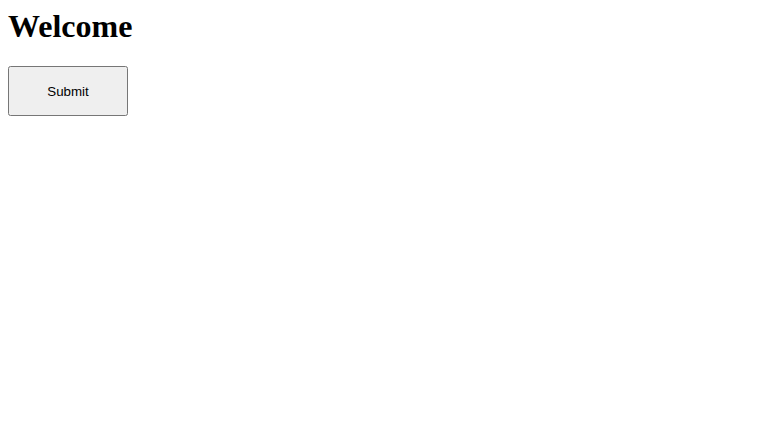

In [20]:
ImageContent("new_layout_rev2.png").show()

We can see now the button has become bigger!